In [1]:
import pandas as pd
import numpy as np
import os, glob
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm, ticker
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

def getinfo(place, year):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime

In [47]:
place = 'Keelung'
year = 2023
path = f'/Volumes/home/Research/Detection_snap/{place}/{str(year)[2:4]}*'


savefig = True


if place == 'Taoyuan':
    begintime, endtime = getinfo(place, year)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_taoyuan{year}.csv')[0]
    lightpath = f'../DataBase/Temperature/Taoyuan/{str(year)[2:4]}*.xlsx'
    rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/467050_新屋/467050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_cwa/{year}_1116_竹圍_tide.csv')[0]
    temp_cwapath = glob.glob(f'../DataBase/Data_CWA/{year}_1116_竹圍_stemp.csv')[0]
    # begintime = datetime(year, 4, 10); endtime = datetime(year, 9, 3)
    # ymin= 0; ymax = 4500 #Taoyuan 04 
    ymin = 0; ymax=6000

elif place == 'Keelung':
    begintime, endtime = getinfo(place, year)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{year}.csv')[0]
    lightpath = f'../DataBase/Temperature/Keelung/{str(year)[2:4]}*.xlsx'
    if year == 2021:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/466940_基隆/466940_{year}.csv')[0]
    else:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/C0B050_八斗子/C0B050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_CWA/{year}_12191_長潭里_tide.csv')[0]
    temp_cwapath = glob.glob(f'../DataBase/Data_CWA/{year}_*長潭里_stemp.csv')[0]
    # begintime = datetime(year, 4, 17, 12); endtime = datetime(year, 5, 3, 12)
    ymin=1000; ymax=16500



print(begintime, endtime)
print(f'sunpath:   {sunpath}')
print(f'lightpath: {lightpath}')
print(f'rainpath:  {rainpath}')
print(f'tidepath:  {tidepath}')
print(f'temppath:  {temp_cwapath}')
dsun = pd.read_csv(sunpath)

2023-04-17 12:00:00 2024-01-06 12:00:00
sunpath:   ../DataBase/Data_CWA/sunset_time_keelung2023.csv
lightpath: ../DataBase/Temperature/Keelung/23*.xlsx
rainpath:  /Volumes/Data/Rainfall_CWA/C0B050_八斗子/C0B050_2023.csv
tidepath:  ../DataBase/Data_CWA/2023_12191_長潭里_tide.csv
temppath:  ../DataBase/Data_CWA/2023_12191_長潭里_stemp.csv


In [48]:
def plotday(ax, begin, end):
    deltaday = endtime - begintime
    print(deltaday)
    
    list = []
    date = []
    for ii in range(deltaday.days):
        time = begin + timedelta(days=ii)
        year = time.year
        month = time.month
        day = time.day
        if year == 2024:
            df = pd.read_csv(glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{year}.csv')[0])
        else:
            df = dsun
        sunset_hr = int((df['SUNSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-2])
        sunset_min = int((df['SUNSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-1])
        sunrise_hr = int((df['SUNRSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-2])
        sunrise_min = int((df['SUNRSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-1])
        duration = datetime(year, month, day, sunset_hr, sunset_min) - datetime(year, month, day, sunrise_hr, sunrise_min)
        duration_min = duration.total_seconds() / 3600
        list.append(duration_min)
        date.append(datetime(year, month, day))
        
    ax.plot(date, list, color='goldenrod', lw=1, ls='--')
    ax.set_ylim(10, 14)
    ax.set_ylabel('Hours of Daylight', fontsize=fsize, color='goldenrod')
    return ax


def plottemp(ax):
    for filepath in glob.glob(f'{lightpath}'):
        dtemp = pd.read_excel(filepath, header=None, names=['Time', 'Temp', 'Light'], skiprows=110, skipfooter=100) 
        filter_temp = savgol_filter(dtemp['Temp'], 60, 2, mode='nearest')
        ax.plot(pd.to_datetime(dtemp['Time']),filter_temp, 'dodgerblue', lw=0.7, alpha=0.75)   
    ax.set_ylabel('Water Temperature (°C)', fontsize=fsize, color='dodgerblue' )
    
    return ax

def plottemp_sta(ax, begintime, endtime):
    def get_strtime(time):
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}00'

    # tidepath = tidepath
    df = pd.read_csv(temp_cwapath, skiprows=9)
    begin = get_strtime(begintime); end = get_strtime(endtime)
    df_ = df[df['yyyymmddhhmi'] >= int(begin)][df['yyyymmddhhmi'] <= int(end)]

    list = []
    for i in range(len(df_)):
        timestr = str(df_['yyyymmddhhmi'].values[i])
        yyyy = int(timestr[:4])
        mm  = int(timestr[4:6])
        dd = int(timestr[6:8])
        hh = int(timestr[8:10])
        minn  = int(timestr[10:])
        list.append(datetime(yyyy,mm,dd,hh,minn))
    ax.plot(list, df_['T'], 'blue', lw=0.5, alpha=0.3)
    
    if place == 'Keelung' and year == 2023:
        temp = glob.glob(f'../DataBase/Data_CWA/2024_*長潭里_stemp.csv')[0]
        df = pd.read_csv(temp, skiprows=9)
        df_ = df[df['yyyymmddhhmi'] >= int('202401010000')][df['yyyymmddhhmi'] <= int(end)]
        list = []
        for i in range(len(df_)):
            timestr = str(df_['yyyymmddhhmi'].values[i])
            yyyy = int(timestr[:4])
            mm  = int(timestr[4:6])
            dd = int(timestr[6:8])
            hh = int(timestr[8:10])
            minn  = int(timestr[10:])
            list.append(datetime(yyyy,mm,dd,hh,minn))
        ax.plot(list, df_['T'], 'blue', lw=0.5, alpha=0.3)        
    return ax
    
    
    
    

264 days 00:00:00
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230417.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230418.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230419.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230420.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230421.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230422.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230423.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230424.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230425.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230426.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230427.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230428.csv
/Volumes/home/Research/Detection_snap/Keelung/

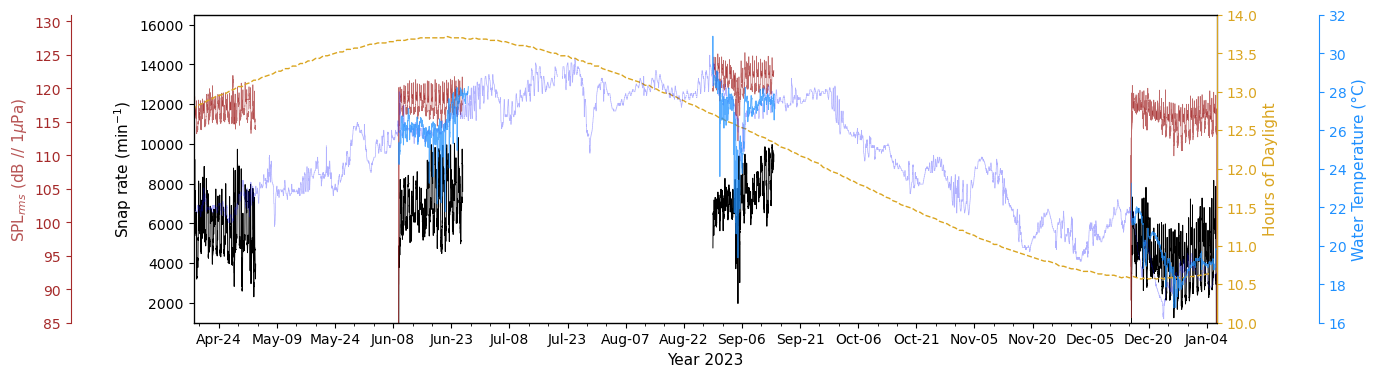

In [49]:
delta_day = (endtime - begintime).days
fig, ax = plt.subplots(1, figsize=(delta_day/20, 4), sharex=True)
plt.rcParams["font.family"] = "DejaVu Sans"

fsize = 11

#=======================================================
ax_SPL = ax.twinx()
ax_daylight = ax.twinx()
ax_temp = ax.twinx()

ax_SPL.spines["left"].set_position(("axes", -0.12))
ax_SPL.yaxis.tick_left()
ax_SPL.yaxis.set_label_position("left")
ax_SPL.spines['left'].set_color('brown')
ax_SPL.tick_params(axis = 'y', color='brown', labelcolor = 'brown')

ax_daylight.spines['right'].set_color('goldenrod')
ax_daylight.tick_params(axis='y', color='goldenrod', labelcolor = 'goldenrod')

ax_temp.spines.right.set_position(("axes", 1.1))
ax_temp.spines['right'].set_color('dodgerblue')
ax_temp.tick_params(axis='y', color='dodgerblue', labelcolor = 'dodgerblue')



ax_daylight = plotday(ax_daylight, begintime, endtime)
ax_temp = plottemp_sta(ax_temp, begintime, endtime)
ax_temp = plottemp(ax_temp)

for filepath in sorted(glob.glob(f'{path}/*csv')):
    
    df = pd.read_csv(filepath)
    gettime = pd.to_datetime(df['Time'].values[0])
    # ax[2] = plotlight(gettime, ax[2])
    # ax[0] = plottide(ax[0], gettime, dtide, ymin, ymax, height_list)
    # ax[1] = plottide(ax[1], gettime, dtide, ymin, ymax, temp)
    filter_peak = savgol_filter(df['Peak'], 60, 2, mode='nearest')
    ax.plot(pd.to_datetime(df['Time']), filter_peak, c='k', lw = 0.7)#marker='o', s=0.5 )
    filter_SPL = savgol_filter(df['SPLrms'], 60, 2, mode='nearest')
    ax_SPL.plot(pd.to_datetime(df['Time']), filter_SPL, c='brown', lw = 0.5, alpha=0.7)#marker='o', s=0.5 )
    print(filepath)
    

ax.set_xlim(begintime, endtime)
ax.set_xlabel(f'Year {year}', fontsize=fsize)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Snap rate (min$^{-1}$)', fontsize=fsize)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))     #optional formatting 
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))   #to get a tick every 15 minutes

ax_SPL.set_ylim(85, 131)
ax_SPL.set_ylabel('SPL$_{rms}$ (dB // 1$\mu$Pa)', fontsize=fsize, color='brown', alpha=0.8)
ax_SPL.yaxis.set_major_locator(ticker.MultipleLocator(5))  

ax_temp.set_ylim(16, 32)


if savefig:
    print('Saving figure. ')
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}_seasonal_variations.png', dpi=200, bbox_inches='tight')
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}_seasonal_variations.pdf', dpi=200)

## Temp and Snap relationship

In [50]:
def get_strtime(time):
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}00'

16500
../DataBase/Temperature/Keelung/230609-230627.xlsx 25769
../DataBase/Temperature/Keelung/230829-230914.xlsx 22886
../DataBase/Temperature/Keelung/231215-240106.xlsx 31486
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230417.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230418.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230419.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230420.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230421.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230422.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230423.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230424.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230425.csv
/Volumes/home/Research/Detection_snap/Keelung/230417-230505/detect_230426.csv
/Volumes/home/Research/Detection_snap/Keelu

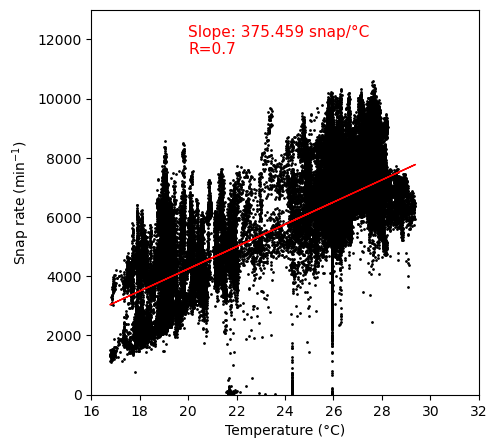

In [53]:
fig, ax = plt.subplots(1, figsize=(5, 5), sharex=True)
plt.rcParams["font.family"] = "DejaVu Sans"
print(ymax)
fsize = 13


alldf = pd.DataFrame()
clear_temp_df = {'Time':[],'Temp':[]}


if glob.glob(lightpath) !=[]:
    alltemp = pd.DataFrame()
    for filepath in glob.glob(f'{lightpath}'):
        dtemp = pd.read_excel(filepath, header=None, names=['Time', 'Temp', 'Light'], skiprows=110, skipfooter=100) 
        alltemp = pd.concat([alltemp, dtemp])
        print(filepath, len(dtemp))
else:  
    alltemp = {'Time':[],'Temp':[]}
    df = pd.read_csv(temp_cwapath, skiprows=9)
    begin = get_strtime(begintime); end = get_strtime(endtime)
    df_ = df[df['yyyymmddhhmi'] >= int(begin)][df['yyyymmddhhmi'] <= int(end)]

    for i in range(len(df_)):
        timestr = str(df_['yyyymmddhhmi'].values[i])
        yyyy = int(timestr[:4])
        mm  = int(timestr[4:6])
        dd = int(timestr[6:8])
        hh = int(timestr[8:10])
        minn  = int(timestr[10:])
        alltemp['Time'].append(datetime(yyyy,mm,dd,hh,minn))
    alltemp['Temp'] = df_['T']
    
    # if place == 'Keelung' and year == 2023:
    #     temp = glob.glob(f'../DataBase/Data_CWA/2024_*長潭里_stemp.csv')[0]
    #     df = pd.read_csv(temp, skiprows=9)
    #     df_ = df[df['yyyymmddhhmi'] >= int('202401010000')][df['yyyymmddhhmi'] <= int(end)]
    #     list = []
    #     for i in range(len(df_)):
    #         timestr = str(df_['yyyymmddhhmi'].values[i])
    #         yyyy = int(timestr[:4])
    #         mm  = int(timestr[4:6])
    #         dd = int(timestr[6:8])
    #         hh = int(timestr[8:10])
    #         minn  = int(timestr[10:])
    #         alltemp['Time'].append(datetime(yyyy,mm,dd,hh,minn))
    
if len(glob.glob(lightpath)) == 2 and place == 'Keelung':
    temp_tmp = {'Time':[], 'Temp':[]}
    df = pd.read_csv(temp_cwapath, skiprows=9)
    begin = '202304170000'; end = '202305130000'
    df_ = df[df['yyyymmddhhmi'] >= int(begin)][df['yyyymmddhhmi'] <= int(end)]    
    for i in range(len(df_)):
        timestr = str(df_['yyyymmddhhmi'].values[i])
        yyyy = timestr[:4]
        mm  = timestr[4:6]
        dd = timestr[6:8]
        hh = timestr[8:10]
        minn  = timestr[10:]
        temp_tmp['Time'].append(np.datetime64(f'{yyyy}-{mm}-{dd}T{hh}:{minn}:00'))
        temp_tmp['Temp'].append(df_['T'].values[i])
    alltemp = pd.concat([alltemp,pd.DataFrame(temp_tmp)])
    
alltemp = pd.DataFrame(alltemp) 
alltemp = alltemp.sort_values(by='Time')
for filepath in sorted(glob.glob(f'{path}/*.csv')):
    
    df = pd.read_csv(filepath)
    for i in range(len(df)):
        
        time = pd.to_datetime(df['Time'].values[i])
        peak = df['Peak'].values[i]
        try:
            corres_time = alltemp[alltemp['Time'] >= np.datetime64(f'{time.year}-{str(time.month).zfill(2)}-{str(time.day).zfill(2)}T{str(time.hour).zfill(2)}:{str(time.minute).zfill(2)}:00')]
            # corres_time = alltemp[alltemp['Time'] <= np.datetime64(f'{time.year}-{str(time.month).zfill(2)}-{str(time.day).zfill(2)}T{str(time.hour).zfill(2)}:{str(time.minute).zfill(2)}:59')]
            corres_temp = corres_time['Temp'].values[0]
            clear_temp_df['Time'].append(time)
            clear_temp_df['Temp'].append(corres_temp)
        except Exception as e:
            clear_temp_df['Time'].append(time)
            clear_temp_df['Temp'].append(np.nan)
            # print(e)
    alldf = pd.concat([alldf, df])
    print(filepath)

    

# alldf = alldf[alldf['Peak']<=ymax]
# alldf = alldf[alldf['SPLrms']<=128]
from scipy import stats
from scipy import stats
clear_temp_df = pd.DataFrame(clear_temp_df)
index = clear_temp_df.loc[pd.isna(clear_temp_df["Temp"]), :].index
index= index.to_list()
clear_temp_df = clear_temp_df.dropna()

alldf = alldf.reset_index(drop=True)
alldf = alldf.drop(index)



res = stats.linregress( clear_temp_df['Temp'], alldf['Peak'])

plt.scatter(clear_temp_df['Temp'], alldf['Peak'],  c='k', marker='o', s=1 )
plt.plot(clear_temp_df['Temp'],  res.intercept + res.slope * np.array(clear_temp_df['Temp']), 'r', lw=1)
print(f"{res.intercept}, {res.slope}, R: {res.rvalue}")


text = f'Slope: {round(res.slope,3)} snap/°C \nR={round(res.rvalue,2)}'
plt.text(20, 13000-1500, text, fontsize=11, color='red')
ax.set_ylim(0, 13000)#ymax)
ax.set_xlim(16, 32)
ax.set_ylabel('Snap rate (min$^{-1}$)')
ax.set_xlabel('Temperature (°C)')
if savefig:
    print('SAVING ....')
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}_temp_relation.png', dpi=200, bbox_inches='tight')
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}_temp_relation.pdf', dpi=200)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 5), sharex=True)
# res = stats.linregress(alldf['Peak'], clear_temp_df['Temp'])
plt.scatter(clear_temp_df['Temp'], alldf['Peak'],  c='k', marker='o', s=1 )
plt.plot(clear_temp_df['Temp'],  res.intercept + res.slope * np.array(clear_temp_df['Temp']), 'r', lw=1)
print(f"{res.intercept}, {res.slope}, R: {res.rvalue}")

text = f'Slope: {round(res.slope,3)} snap/°C \nR={round(res.rvalue,2)}'
plt.text(22, ymax-1000, text, fontsize=11, color='red')
ax.set_ylim(0, ymax)
ax.set_xlim(21, 32)
ax.set_ylabel('Snap rate (min$^{-1}$)')
ax.set_xlabel('Temperature (°C)')

In [6]:
alldf

""
